### Counterfactual explanation on time series anomaly detection

This is an example of our optimization-based counterfactual explainer `MACEExplainer` for time series data. This explainer only supports time series anomaly detection.

In [1]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [2]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import os
import numpy as np
import pandas as pd
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import MACEExplainer

The time series data used here is a sythentic univariate time series dataset. We recommend using `Timeseries` to represent a time series dataset. `Timeseries` contains one univariate/multivariate time series, which can be constructed from a pandas dataframe (the index in the dataframe indicates the timestamps and the columns are the variables).

In [4]:
# Load the time series dataset
df = pd.read_csv(os.path.join("../data", "timeseries.csv"))
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
df = df.rename(columns={"horizontal": "values"})
df = df.set_index("timestamp")
df = df.drop(columns=["anomaly"])
print(df)

                       values
timestamp                    
1970-01-01 00:00:00  1.928031
1970-01-01 00:05:00 -1.156620
1970-01-01 00:10:00 -0.390650
1970-01-01 00:15:00  0.400804
1970-01-01 00:20:00 -0.874490
...                       ...
1970-02-04 16:55:00  0.362724
1970-02-04 17:00:00  2.657373
1970-02-04 17:05:00  1.472341
1970-02-04 17:10:00  1.033154
1970-02-04 17:15:00  2.950466

[10000 rows x 1 columns]


In [5]:
# Split the dataset into training and test splits
train_df = df.iloc[:9150]
test_df = df.iloc[9150:9300]
# A simple threshold for detecting anomaly data points
threshold = np.percentile(train_df["values"].values, 90)

The outputs of the detector are anomaly scores instead of anomaly labels (0 or 1). A data point is more anomalous if it has a higher anomaly score. 

In [6]:
# A simple detector for determining whether a window of time series is anomalous
def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > threshold).astype(int))
    return anomaly_scores / ts.shape[0]

To initialize a MACEExplainer explainer, we need to set:
  
  - `training_data`: The data used to initialize a MACEExplainer explainer. ``training_data`` can be the training dataset for training the machine learning model.
  - `predict_function`: The prediction function corresponding to the model to explain. The input of ``predict_function`` should be an `Timeseries` instance. The outputs of ``predict_function`` are anomaly scores (higher scores imply more anomalous) for anomaly detection.
  - `threshold`: The threshold to determine whether an instance is anomalous, e.g., anomaly score > threshold.

In [7]:
explainer = MACEExplainer(
    training_data=Timeseries.from_pd(train_df),
    predict_function=detector,
    mode="anomaly_detection",
    threshold=0.001
)
test_x = Timeseries.from_pd(test_df)

MACE Debug: Original score=0.2800, Threshold=0.0010
MACE Debug: Label=1, less_than_threshold=True
MACE Debug: Target=reduce score below threshold
 |███████████████████████████████████████-| 99.5% MACE Debug: Trying 150 optimal modifications
MACE Debug: Original reward=-0.2790
MACE Debug: Modification 1, column=19, reward=-0.2723
MACE Debug: Modification 2, column=22, reward=-0.2723
MACE Debug: Modification 3, column=23, reward=-0.2723
MACE Debug: Modification 4, column=24, reward=-0.2723
MACE Debug: Modification 5, column=25, reward=-0.2723
MACE Debug: Individual modifications failed, trying cumulative...
MACE Debug: Cumulative 1, reward=-0.2723
MACE Debug: Cumulative 2, reward=-0.2657
MACE Debug: Cumulative 3, reward=-0.2590
MACE Debug: Cumulative 4, reward=-0.2523
MACE Debug: Cumulative 5, reward=-0.2457
MACE Debug: Found counterfactual with cumulative modification 42!


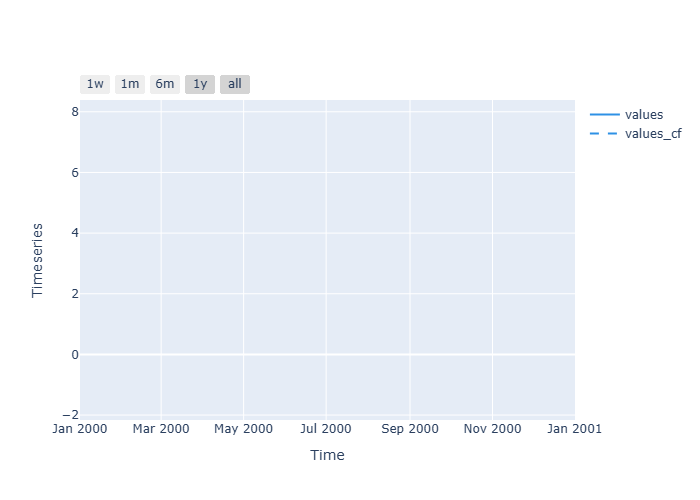

In [8]:
explanations = explainer.explain(test_x)
explanations.ipython_plot()